<h1>Linear Regression tests with emcee</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from chain_analysis import contour_plot, gelman_rubin
import emcee

plt.rcParams['figure.figsize']=(8,7)
plt.style.use('seaborn-whitegrid')

**Warning** : Hereafter for simplicity we assumed errors and standard deviation to be equal to one!

<h2>I. Y = mX</h2>

<p>Hereafter we compare several cases and their effect on the posterior distribution :</p>

m = 0.538788931465258


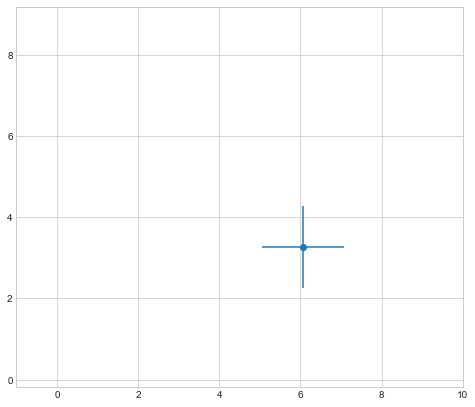

In [3]:
# generating a random single point in range [0,10] and a random slope "m"
x = 2.0*np.random.rand()+5.0
m = np.random.rand()
y = m*x
yerr = 1.0
xerr = 1.0

print('m = {}'.format(m))
_=plt.errorbar(x,y,xerr=xerr,yerr=yerr,ls='',marker='o')
plt.axis('equal')
_=plt.xlim(-1.0,10.0)
_=plt.ylim(-1.0,10.0)


<h3>Considering error along y-axis only</h3>

In [4]:
### Log Likelihood ###

def lnlkl(p, x, y, yerr):
    y_model = p*x
    return -0.5 * (np.power(y-y_model,2)/yerr**2 + np.log(2*np.pi*yerr**2))

In [5]:
### Log Prior ###
# Using flat priors (just to bound the posterior)

def lnprior(z):
    if -100.0 < z < 100.0:
        return 0.0
    return -np.inf

In [6]:
### Log Probability ###
# No bouding prior

def lnprob(p, x, y, yerr):
    lpm = lnprior(p)
    if not np.isfinite(lpm):
        return -np.inf
    return lpm + lnlkl(p, x, y, yerr)

In [7]:
### Ensemble Method ###
n_walker=50
n_steps=4000
ndim=1

# Wakers initial positions
pos0 = np.c_[np.random.rand(n_walker)-0.5]

sampler_Ey = emcee.EnsembleSampler(n_walker, ndim, lnprob,args=(x,y,yerr))
pos,_,_=sampler_Ey.run_mcmc(pos0 = pos0 , N=100)
sampler_Ey.reset()
_=sampler_Ey.run_mcmc(pos0 = pos , N=n_steps)

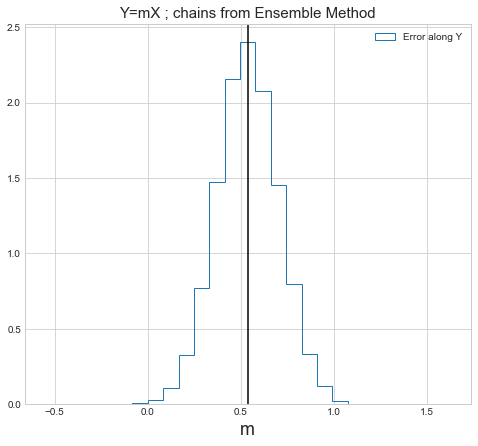

In [8]:
_=plt.hist(sampler_Ey.chain[:,:,:].ravel(),bins=np.linspace(m-1.2,m+1.2,30),histtype='step',normed=True)
plt.legend(['Error along Y'])
plt.axvline(m,color='k')
plt.title('Y=mX ; chains from Ensemble Method',fontsize=15)
plt.xlim(m-1.2,m+1.2)
plt.xlabel('m',fontsize=18)

<h3>Considering errors along both axis</h3>

In [9]:
### Log Likelihood ###

def lnlkl(p, x, xerr, y, yerr):
    y_model = p*x
    C = (p*xerr)**2 + yerr**2
    return -0.5 * (np.divide(np.power(y-y_model,2), C) + np.log(2*np.pi*C))

def lnprob(p, x, xerr, y, yerr):
    lpm = lnprior(p)
    if not np.isfinite(lpm):
        return -np.inf
    return lpm + lnlkl(p, x, xerr, y, yerr)

In [10]:
### Ensemble Method ###
n_walker=50
n_steps=4000
ndim=1

# Wakers initial positions
pos0 = np.c_[np.random.rand(n_walker)-0.5]

sampler_Exy = emcee.EnsembleSampler(n_walker, ndim, lnprob, args=(x,xerr,y,yerr))
pos,_,_=sampler_Exy.run_mcmc(pos0 = pos0 , N=100)
sampler_Exy.reset()
_=sampler_Exy.run_mcmc(pos0 = pos , N=n_steps)

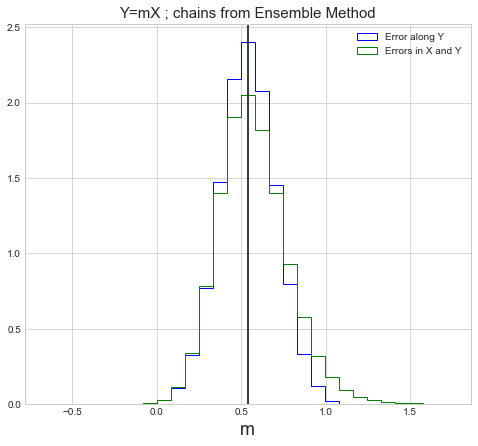

In [11]:
_=plt.hist(sampler_Ey.chain[:,:,:].ravel(),bins=np.linspace(m-1.2,m+1.2,30),histtype='step',color='b',normed=True)
_=plt.hist(sampler_Exy.chain[:,:,:].ravel(),bins=np.linspace(m-1.2,m+1.2,30),histtype='step',color='g',normed=True)
plt.legend(('Error along Y','Errors in X and Y'))
plt.axvline(m,color='k')
plt.title('Y=mX ; chains from Ensemble Method',fontsize=15)
plt.xlabel('m',fontsize=18)
#plt.savefig('ymx_emcee_test.png')

<h2>II. Y = mX+p</h2>

m = -0.9216351473694502 and p = -0.5645146161438885


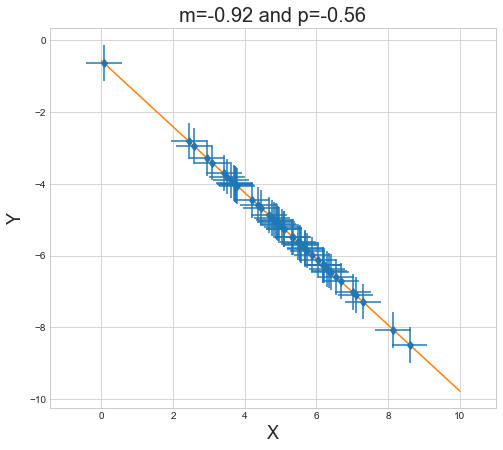

In [157]:
#Random slope and intercept
m = 2.0*(np.random.rand()-0.5)
p = 2.0*(np.random.rand()-0.5)

# generating easy data without scatter
#xl = np.arange(10)
xp = 1.5
xl = np.random.normal(loc=5.0,scale=xp,size=50)
yl = m*xl + p
ylerr = np.ones_like(yl)*0.5
xlerr = np.ones_like(xl)*0.5

# generating easy data with scatter
#x = np.arange(10) + 2.0*(np.random.rand(10)-0.5)
#y = m*x + p + (np.random.rand(10)-0.5)

print('m = {} and p = {}'.format(m,p))
_=plt.errorbar(xl,yl,xerr=xlerr,yerr=ylerr,marker='d',ls='')
plt.plot(np.arange(11),m*np.arange(11)+p)
plt.axis('equal')
plt.title('m={:.2f} and p={:.2f}'.format(m, p),fontsize=20)
plt.xlabel('X',fontsize=18)
plt.ylabel('Y',fontsize=18)

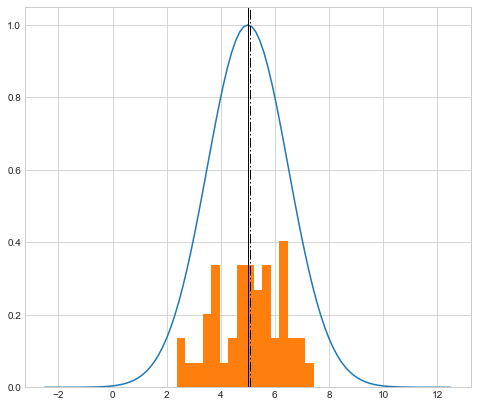

In [159]:
plt.plot(np.linspace(5.0-5*xp,5.0+5*xp,101),
         np.exp(-(5.0-np.linspace(5.0-5*xp,5.0+5*xp,101))**2/(2*xp**2)))
_=plt.hist(xl,bins=np.linspace(xl.mean()-3.0,xl.mean()+3.0,20),normed=True)
plt.axvline(5.0,lw=1.0,color='k')
plt.axvline(xl.mean(),lw=1.0,color='k',linestyle='-.')

<h3>II.a. Considering error along y-axis only</h3>

In [160]:
### Log Likelihood ###

def lnlkl(p, x, y, yerr):
    y_model = p[0]*x + p[1]
    return -0.5 * np.nansum(np.power(y-y_model,2)/yerr**2 + np.log(2*np.pi*yerr**2))

In [161]:
### Log Probability ###
# without bounding priors

def lnprob(p, x, y, yerr):
    lpm = lnprior(p[0])
    lpp = lnprior(p[1])
    if not np.isfinite(lpm) or not np.isfinite(lpp):
        return -np.inf
    return lpm + lpp + lnlkl(p, x, y, yerr)

In [166]:
### Ensemble Method ###
n_walker=50
n_steps=10000
ndim=2

# Walkers initial positions
pos0 = np.c_[np.random.rand(n_walker)-0.5,np.random.rand(n_walker)-0.5]

sampler_Ey = emcee.EnsembleSampler(n_walker, ndim, lnprob, args=(xl,yl,ylerr))
pos,_,_=sampler_Ey.run_mcmc(pos0 = pos0 , N=2000)
sampler_Ey.reset()
_=sampler_Ey.run_mcmc(pos0 = pos , N=n_steps)

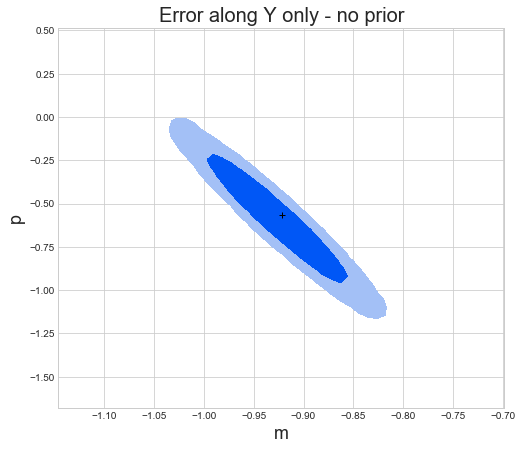

In [194]:
contour_plot.contour(sampler_Ey.chain[:,:,:].reshape([50*10000,2]), [0,1], smooth=1e6)
#plt.scatter(sampler_Ey.chain[:,:,0].ravel(),sampler_Ey.chain[:,:,1].ravel(),marker='+',color='y')
#contour_plot.contour(sampler_Ey.chain[:,:,:].reshape([50*10000,2]), [0,1], smooth=1e6,line=True, col='k')

plt.plot(m,p,'+k')
plt.title('Error along Y only - no prior',fontsize=20)
plt.xlabel('m',fontsize=18)
plt.ylabel('p',fontsize=18)

<h3>Considering errors along both axis</h3>

In [168]:
### Log Likelihood ###

def lnlkl(p, x, xerr, y, yerr):
    y_model = p[0]*x + p[1]
    C = (p[0]*xerr)**2 + yerr**2
    return -0.5 * np.nansum(np.divide(np.power(y-y_model,2), C) + np.log(2*np.pi*C))

def lnprob(p, x, xerr, y, yerr):
    lpm = lnprior(p[0])
    lpp = lnprior(p[1])
    if not np.isfinite(lpm) or not np.isfinite(lpp):
        return -np.inf
    return lpm+ lpp + lnlkl(p, x, xerr, y, yerr)

In [169]:
### Ensemble Method ###
n_walker=50
n_steps=10000
ndim=2

# Wakers initial positions
pos0 = np.c_[np.random.rand(n_walker)-0.5,np.random.rand(n_walker)-0.5]

sampler_Exy = emcee.EnsembleSampler(n_walker, ndim, lnprob, args=(xl,xlerr,yl,ylerr))
pos,_,_=sampler_Exy.run_mcmc(pos0 = pos0 , N=2000)
sampler_Exy.reset()
_=sampler_Exy.run_mcmc(pos0 = pos , N=n_steps)

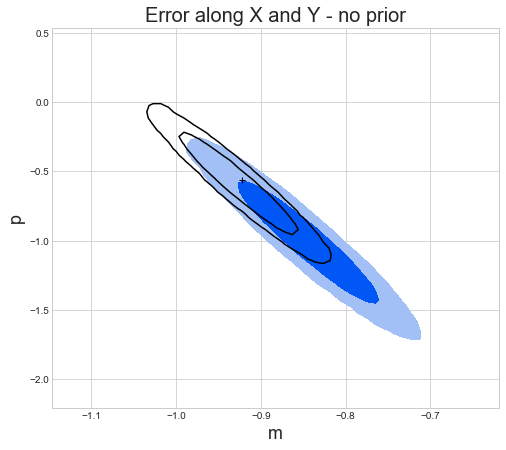

In [195]:
contour_plot.contour(sampler_Exy.chain[:,:,:].reshape([50*10000,2]), [0,1], smooth=1e6)
contour_plot.contour(sampler_Ey.chain[:,:,:].reshape([50*10000,2]), [0,1], smooth=1e6,line=True, col='k')
plt.plot(m,p,'+k')
plt.title('Error along X and Y - no prior',fontsize=20)
plt.xlabel('m',fontsize=18)
plt.ylabel('p',fontsize=18)